# **Understanding the Data Science Job Market**

### **Setting the scene**

In this notebook, we investigate a data set of web scraped data science jobs from Glassdoor in February 2021, compiled by [Rashik Rahman](https://www.kaggle.com/rashikrahmanpritom), found on Kaggle [here](https://www.kaggle.com/rashikrahmanpritom/data-science-job-posting-on-glassdoor).
We initially do some high-level exploratory analysis, followed by a brief attempt to see whether a linear regression model can shed some light on the data science job market.

---

Summary:

*   Posted salary does not correlate with size of the company or revenue generated
*   List item

---

### **Importing required libraries and data**

First we import the libraries that we might need and take a glimpse at the data

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import plotly.express as px

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

import random

import json
%matplotlib inline

In [3]:
random.seed(0)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!wget --no-check-certificate \
    'https://docs.google.com/spreadsheets/d/e/2PACX-1vQQPg9_DhCbQuz2t2EXJoiCgeOSA-0-jKZ6zk0XyBQlzFQMDFjdQILRPoNTm9K8l2xHS44Ke9KK_KUp/pub?gid=303885414&single=true&output=csv' \
    -O /tmp/dataset.csv

scraped_jobs_data = pd.read_csv('/tmp/dataset.csv', sep=',')

In [5]:
scraped_jobs_data.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Type of ownership,Industry,Sector,Revenue,min_salary,max_salary,avg_salary,job_state,same_state,company_age,python,excel,hadoop,spark,aws,tableau,big_data,job_simp,seniority
0,Sr Data Scientist,137-171,Description\n\nThe Senior Data Scientist is re...,3.1,Healthfirst,"New York, NY","New York, NY",1001 to 5000 employees,Nonprofit Organization,Insurance Carriers,Insurance,Unknown / Non-Applicable,137,171,154,NY,1,27,0,0,0,0,1,0,0,data scientist,senior
1,Data Scientist,137-171,"Secure our Nation, Ignite your Future\n\nJoin ...",4.2,ManTech,"Chantilly, VA","Herndon, VA",5001 to 10000 employees,Company - Public,Research & Development,Business Services,$1 to $2 billion (USD),137,171,154,VA,0,52,0,0,1,0,0,0,1,data scientist,na
2,Data Scientist,137-171,Overview\n\n\nAnalysis Group is one of the lar...,3.8,Analysis Group,"Boston, MA","Boston, MA",1001 to 5000 employees,Private Practice / Firm,Consulting,Business Services,$100 to $500 million (USD),137,171,154,MA,1,39,1,1,0,0,1,0,0,data scientist,na
3,Data Scientist,137-171,JOB DESCRIPTION:\n\nDo you have a passion for ...,3.5,INFICON,"Newton, MA","Bad Ragaz, Switzerland",501 to 1000 employees,Company - Public,Electrical & Electronic Manufacturing,Manufacturing,$100 to $500 million (USD),137,171,154,MA,0,20,1,1,0,0,1,0,0,data scientist,na
4,Data Scientist,137-171,Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions,"New York, NY","New York, NY",51 to 200 employees,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,137,171,154,NY,1,22,1,1,0,0,0,0,0,data scientist,na


In [6]:
scraped_jobs_data.describe()

,Rating,min_salary,max_salary,avg_salary,same_state,company_age,python,excel,hadoop,spark,aws,tableau,big_data
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,3.587424,99.296970,148.301515,123.612121,0.407576,29.736364,0.730303,0.440909,0.212121,0.281818,0.260606,0.184848,0.206061
std,1.183540,33.161485,48.264588,39.786698,0.491756,39.763033,0.444139,0.496873,0.409120,0.450226,0.439298,0.388469,0.404781
min,0.000000,31.000000,56.000000,43.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.300000,79.000000,119.000000,103.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.800000,91.000000,133.000000,114.000000,0.000000,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.300000,122.000000,165.000000,136.000000,1.000000,37.250000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,5.000000,212.000000,331.000000,271.000000,1.000000,239.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Address empty values
print('Proportion of empty values in dataset:')
print(scraped_jobs_data.isnull().sum() / scraped_jobs_data.count())

### **Questions to ask**


In our analysis of the data science job market, several key questions come to mind:

> 1.   Which sectors are hiring the most data science professionals at the moment?
>
> 2.   Which skills do hiring companies require from different data science professionals?
>
> 3.   Which skills tend to contribute the most to a higher estimated salary?
>
> 4.   Does the size of the company influence the estimated salary?
>

So let's try to answer the first question


### **Which sectors are hiring the most data science professionals at the moment?**
We attempt to answer this question by plotting a bar chart of number of job postings by sector. We use the job_simp column that shows a simplified version of the job title and ignoring unknown job titles. In addition, we ignore unannotated company sectors as they will serve no purpose in answering our question.





array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f58e88f5490>,
      dtype=object)

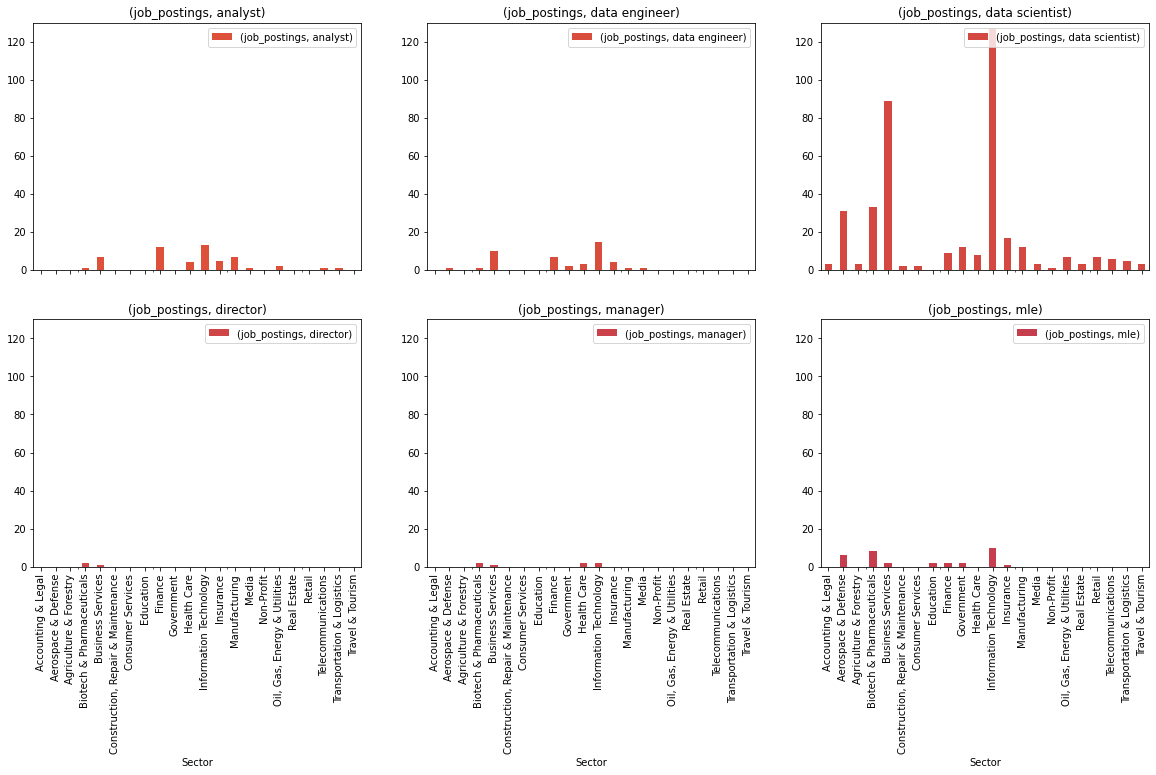

In [89]:
# Filter out unknown rows for target columns
scraped_jobs_data_cleaned = scraped_jobs_data.loc[(scraped_jobs_data['job_simp'] != 'na') & (scraped_jobs_data['Sector'] != '-1')].reset_index()

# Group by sector and simplified job titles for visualization
scraped_jobs_data_cleaned_grouped = scraped_jobs_data_cleaned[['job_simp', 'Sector', 'index']].groupby(['Sector', 'job_simp']).count()

# Rename index column for better readability
scraped_jobs_data_cleaned_grouped = scraped_jobs_data_cleaned_grouped.rename(columns={"index": "job_postings"})

# Customize the colours
from matplotlib import cm
color = cm.inferno_r(np.linspace(.4, .8, 30))

# Plot data science job postings by sector
scraped_jobs_data_cleaned_grouped.unstack().plot(kind='bar', subplots=True, layout=(2,3), figsize=(20,10), color=color, ylim=(0,130))

It appears that companies in the Information Technology sector are hiring the most data science professionals across all job types (except for data science directors).

Interestingly, companies engaged in the Business Services sector seem to be the second highest hirers of data science professionals. This is consistent across the two most popular job titles, i.e, data scientist and data engineer.

However, the demand for the third most popular job title (data analyst) is more evenly distributed across sectors relative to the other job titles.

In [98]:
scraped_jobs_data[skills_to_be_analyzed].mean().sort_values(ascending=False)

python          0.730303
sql             0.533333
excel           0.440909
spark           0.281818
aws             0.260606
github          0.218182
hadoop          0.212121
big_data        0.206061
tableau         0.184848
tensorflow      0.150000
pytorch         0.080303
azure           0.075758
power_bi        0.051515
google_cloud    0.050000
airflow         0.013636
dtype: float64

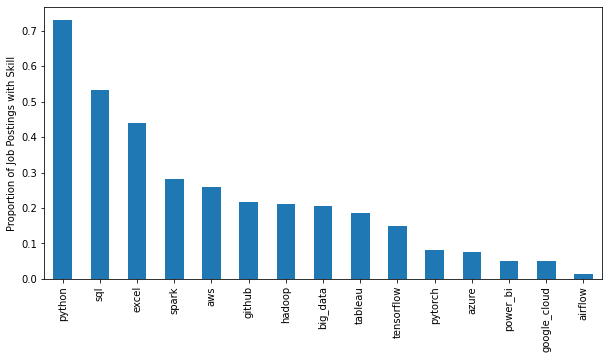

In [99]:
skills_to_be_analyzed = ['power_bi', 'tensorflow', 'pytorch', 'sql', 'airflow', 'azure', 'github', 'google_cloud', 'python', 'excel', 'hadoop', 'spark', 'aws', 'tableau', 'big_data']

scraped_jobs_data['power_bi'] = scraped_jobs_data['Job Description'].apply(lambda x: 1 if 'power bi' in x.lower() else 0)
scraped_jobs_data['tensorflow'] = scraped_jobs_data['Job Description'].apply(lambda x: 1 if 'tensorflow' in x.lower() else 0)
scraped_jobs_data['pytorch'] = scraped_jobs_data['Job Description'].apply(lambda x: 1 if 'pytorch' in x.lower() else 0)
scraped_jobs_data['sql'] = scraped_jobs_data['Job Description'].apply(lambda x: 1 if 'sql' in x.lower() else 0)
scraped_jobs_data['airflow'] = scraped_jobs_data['Job Description'].apply(lambda x: 1 if 'airflow' in x.lower() else 0)
scraped_jobs_data['azure'] = scraped_jobs_data['Job Description'].apply(lambda x: 1 if 'azure' in x.lower() else 0)
scraped_jobs_data['github'] = scraped_jobs_data['Job Description'].apply(lambda x: 1 if 'git' in x.lower() else 0)
scraped_jobs_data['google_cloud'] = scraped_jobs_data['Job Description'].apply(lambda x: 1 if ('google cloud' in x.lower()) | ('gcp' in x.lower()) else 0)

scraped_jobs_data[skills_to_be_analyzed].mean().sort_values(ascending=False).plot(kind='bar', figsize=(10,5), ylabel='Proportion of Job Postings with Skill')

# scraped_jobs_data_wo_na_titles = scraped_jobs_data.loc[scraped_jobs_data['job_simp'] != 'na']

# skills_to_be_analyzed.append('job_simp')
# skills_plus_job_title_columns = skills_to_be_analyzed

# scraped_jobs_data_skills_grouped = scraped_jobs_data_wo_na_titles[skills_plus_job_title_columns].groupby(['job_simp']).mean()

# scraped_jobs_data_skills_grouped.transpose().plot(kind='bar', subplots=True, layout=(2,3), figsize=(20,10), color=color, ylim=(0,0.9), ylabel='Proportion of Job Postings with Skill')

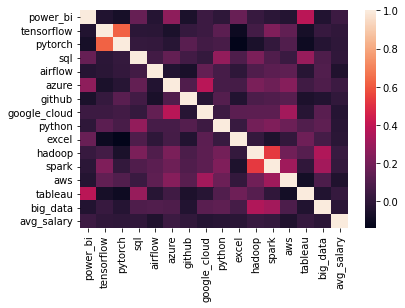

In [102]:
columns = ['power_bi', 'tensorflow', 'pytorch', 'sql', 'airflow', 'azure', 'github', 'google_cloud', 'python', 'excel', 'hadoop', 'spark', 'aws', 'tableau', 'big_data', 'avg_salary']
sns.heatmap(scraped_jobs_data[columns].corr(), annot=False, fmt=".2f");

In [108]:
X = scraped_jobs_data[skills_to_be_analyzed]
y = (scraped_jobs_data['avg_salary']-scraped_jobs_data['avg_salary'].min())/(scraped_jobs_data['avg_salary'].max()-scraped_jobs_data['avg_salary'].min())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

lm_model = LinearRegression(normalize=True) # Here you could set any hyperparameters of your model
lm_model.fit(X_train, y_train)

y_test_preds = lm_model.predict(X_test)

print(r2_score(y_test, y_test_preds)) # In this case we are predicting a continuous, numeric response.  Therefore, common
print(mean_squared_error(y_test, y_test_preds)) # metrics to assess fit include Rsquared and MSE.

-0.023793881843306552
0.030415253093054522


In [109]:
coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(lm_model.coef_))], axis = 1)
coefficients

,0,0
0,power_bi,0.018580
1,tensorflow,0.004787
2,pytorch,0.011598
3,sql,-0.003010
4,airflow,-0.036919
5,azure,0.030436
6,github,0.007653
7,google_cloud,-0.000882
8,python,-0.004659
9,excel,-0.006785
